# Boundary value problems

## Oscillations of a string with varying density

The oscillations of a string are governed by the equation 

$$\rho(x) {d^2 \xi\over dt^2} - T{\partial^2 \xi\over\partial x^2} = 0,$$

where $\xi$ is the vertical displacement (assumed small), $T$ is the tension (assumed constant), and $\rho(x)$ is the mass per unit length, which here we take to depend on the coordinate $x$ along the string. Assume that the string is fixed at both ends, so that $\xi=0$ at $x=0$ and $x=L$.

For a normal mode of the string $\xi\propto e^{i\omega t}$, we find

$${\partial^2\xi\over\partial x^2} = -{\omega^2 \rho(x)\over T} \xi.$$


## Shooting method

To solve this using a shooting method, we write this as two first order ODEs,

$${\partial f\over \partial x} = g$$

$${\partial g\over\partial x} = -{\omega^2 \rho(x)\over T} f$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
import scipy.special

Found omega = 1.00001 pi, n = 0
Found omega = 2.00002 pi, n = 1
Found omega = 3.00003 pi, n = 2
Found omega = 4.00004 pi, n = 3
Found omega = 5.00005 pi, n = 4
Found omega = 6.00006 pi, n = 5


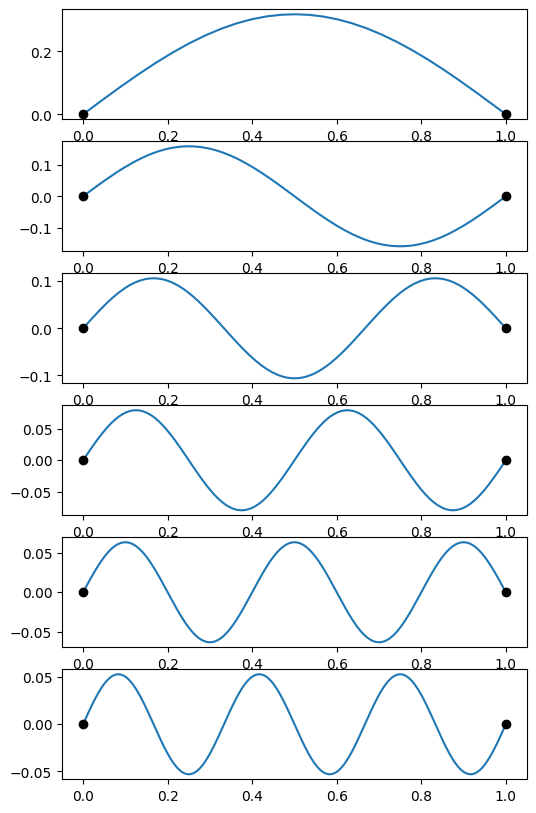

In [2]:
# First do the constant density string to check with the known frequencies
# and eigenfunctions

def derivs(x, y, omega):
    f, g = y
    dfdx = g
    density = 1
    dgdx = - omega**2 * density * f
    return dfdx, dgdx

def do_integration(omega):
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    return result.y[0,-1]

fig = plt.figure(figsize = (6,10))

oms = np.pi * np.array((1,2,3,4,5,6))
num = len(oms)

for i, om in enumerate(oms):
    omega = scipy.optimize.brentq(do_integration, 0.9*om, 1.1*om)
    
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    x = result.t
    f = result.y[0]

    # find the number of zero crossings (not including the endpoints)
    n = ((f[1:-1] * f[:-2]) < 0).sum()
    print("Found omega = %lg pi, n = %d" % (omega/np.pi,n))

    plt.subplot(num,1,1+i)
    plt.plot(x, f)
    plt.plot((0,1),(0,0), 'ko')

plt.show()

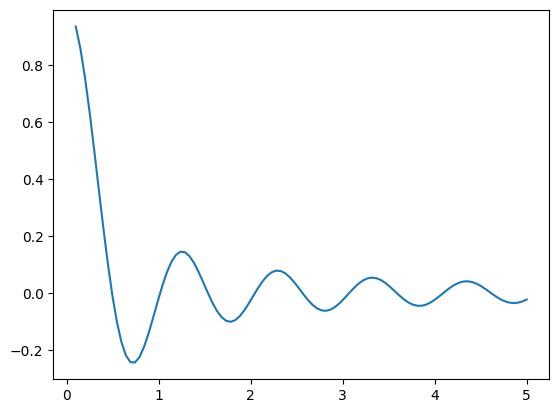

[0.44646465 0.99090909 1.48585859 2.03030303 2.52525253 3.06969697
 3.56464646 4.05959596 4.6040404 ]
Found omega = 0.493438 pi, n = 0
Found omega = 1.01755 pi, n = 1
Found omega = 1.53483 pi, n = 2
Found omega = 2.0489 pi, n = 3
Found omega = 2.56151 pi, n = 4
Found omega = 3.0735 pi, n = 5
Found omega = 3.58524 pi, n = 6
Found omega = 4.0969 pi, n = 7
Found omega = 4.60855 pi, n = 8


<Figure size 640x480 with 0 Axes>

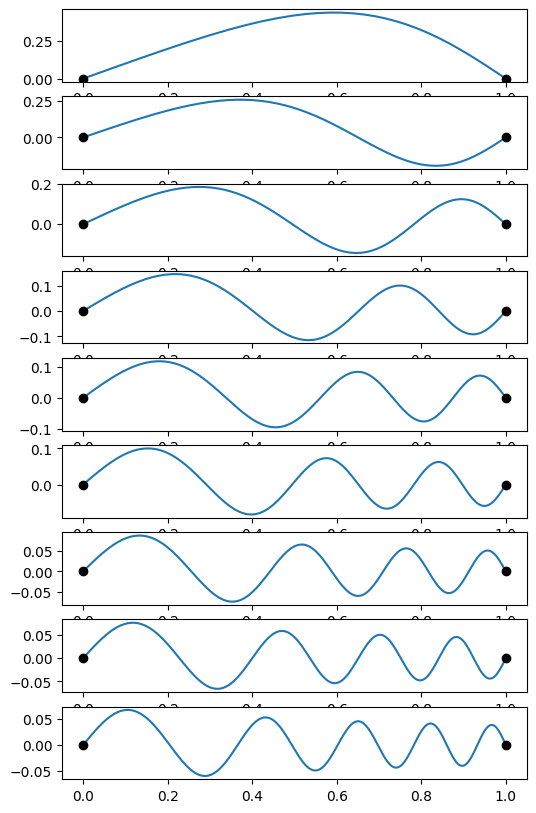

In [3]:
# Now do an x-dependent density

def derivs(x, y, omega):
    f, g = y
    dfdx = g
    density = 1 + 10*x**2
    dgdx = - omega**2 * density * f
    return dfdx, dgdx

def do_integration(omega):
    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    return result.y[0,-1]

oms = np.pi * np.linspace(0.1,5,100)
result = np.array([do_integration(om) for om in oms]) 
plt.plot(oms/np.pi, result)
plt.show()
inds = np.where(np.diff(np.sign(result)))[0]
print(oms[inds]/np.pi)

plt.clf()
num = len(inds)
fig = plt.figure(figsize = (6,10))

for i, ind in enumerate(inds):
    omega = scipy.optimize.brentq(do_integration, oms[ind], oms[ind+1])

    result = scipy.integrate.solve_ivp(derivs, (1e-5,1), (0,1), dense_output=True, args=(omega,), atol=1e-8, rtol=1e-8)
    x = result.t
    f = result.y[0]

    # find the number of zero crossings (not including the endpoints)
    n = ((f[1:-1] * f[:-2]) < 0).sum()
    print("Found omega = %lg pi, n = %d" % (omega/np.pi,n))

    plt.subplot(num,1,1+i)
    plt.plot(x, f)
    plt.plot((0,1),(0,0), 'ko')

plt.show()

# Store the last eigenfunction we found to compare later with the relaxation result
x_s = x
f_s = f
om_s = omega


## Relaxation method

For the relaxation method, we can work with the second order equation

$${\partial^2 f\over\partial x^2} = -{\omega^2 \rho(x)\over T} f.$$


Set $T=1$ for simplicity and finite-difference this on a grid in $x$:

$${f_{i+1}-2f_i+f_{i-1}\over (\Delta x)^2} = - \omega^2\rho_i f_i,$$

where $\rho_i$ is the density at $x=x_i$.

We therefore need to find the solution of

$$G_i = f_{i+1} - \left[2 - (\Delta x)^2\omega^2\rho_i)\right] f_i+f_{i-1} = 0$$

for $i=2$ to $N-1$, together with the boundary conditions

$$G_1 = f_1 = 0 \hspace{1cm} G_N = f_N=0.$$



We can find the root using Newton's method

$$G^{n+1}_i = G^n_i + {\partial G^n_i\over \partial f_j}(f_j^{n+1}-f_j^n) = 0$$

or defining the Jacobian matrix $J_{ij} = \partial G_i/\partial f_j$, 

$$G^{n+1}_i = G^n_i + J_{ij}(f_j^{n+1}-f_j^n) = 0$$

$$\Rightarrow f_j^{n+1} = f_j^n + (J^{-1})_{ji} G^n_i $$

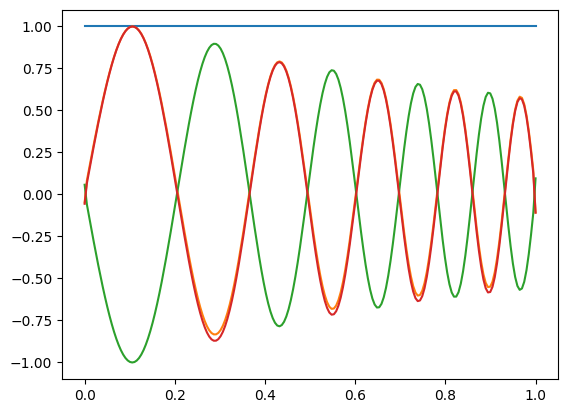

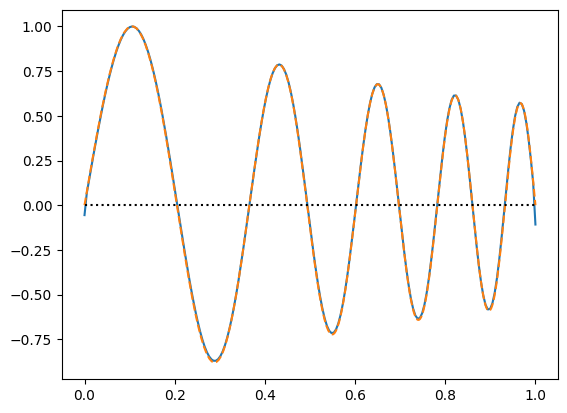

In [7]:
def calculate_G(f, x, omega):
    G = np.zeros(ngrid)
    dx = x[1]-x[0]  # assume constant spacing
    rho = 1.0 + 10*x**2
    #rho = np.ones_like(x)
    G[1:-1] = f[2:] - (2 - dx**2 * omega**2 * rho[1:-1])*f[1:-1] + f[:-2]
    G[0] = f[0]
    G[-1] = f[-1]
    return G

def calculate_J(f, x, omega):
    eps = 1e-6
    J = np.zeros((ngrid, ngrid))
    G1 = calculate_G(f, x, omega)
    for j in range(ngrid):
        f1 = np.copy(f)
        df = max(f[i]*eps,eps)
        f1[j] = f[j] + df
        G2 = calculate_G(f1, x, omega)
        J[j,:] = (G2-G1)/df
    return J

# grid
#omega = np.pi * 4.60855 
# Use the frequency from the shooting method:
omega = om_s
ngrid = 200
x = np.linspace(0,1,ngrid)

# Initial guess
f = np.ones_like(x)
plt.plot(x, f)

niter = 3
for m in range(niter):
    
    G = calculate_G(f, x, omega)
    J = calculate_J(f, x, omega)
    f = f + np.linalg.inv(J)@G
    f = f / max(np.abs(f))
    plt.plot(x, f)
    
plt.show()

plt.clf()
plt.plot(x,f)
# compare with the analytic solution for constant density:
#plt.plot(x, np.sin(5 * np.pi * x), ":")
# compare with the shooting result:
plt.plot(x_s, f_s * max(f)/max(f_s), "--")
plt.plot((0,1),(0,0),"k:")
plt.show()